# Candlestick Analysis with Clustering and Reinforcement Learning

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
import mplfinance as mpf
import itertools
import random
from collections import Counter

In [6]:
data = (pd.read_csv('../data/dados.csv', index_col=0, parse_dates=True))[::-1]

data = data.drop(columns=['EMAVG (9) on Close',
       'Moving Average(Simple,21,0)', 'MACD(12,26)', 'Sig(9)', 'Diff',
       'Volume', 'Daily Avg(5)', 'Daily Accum Vol', 'Daily Accum Avg Vol']).dropna()

# alguns números estaja em formato diferente, multipliquei por 1000 para que ficasse equivalente com os demais, preciso dar uma limapada nesse codigo
for col in ['Open', 'Close', 'High', 'Low']:
    data.loc[data[col] < 1000, col] *= 1000

data_original = data.copy()

/tmp/ipykernel_83121/3402031634.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = (pd.read_csv('../data/dados.csv', index_col=0, parse_dates=True))[::-1]


In [7]:
# Normalization of data

scaler = Normalizer()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [9]:
def add_features(data):
    
    data['body'] = (data['Close'] - data['Open']) / data['Open'] * 100
    data['upper_shadow'] = ((data['High'] - data[['Open', 'Close']].max(axis=1)) / data['Open']) * 100
    data['lower_shadow'] = ((data[['Open', 'Close']].min(axis=1) - data['Low']) / data['Open']) * 100

    return data

In [10]:
data = add_features(data)
data_original = add_features(data_original)

data = data[(data['upper_shadow'] < 2) & (data['lower_shadow'] < 2)]

## Clustering

In [11]:
def fit_individual_clusters(data, n_body_clusters, n_lower_shadow_clusters, n_upper_shadow_clusters):
    models = {
        'body': KMeans(n_clusters=n_body_clusters, random_state=42),
        'lower_shadow': KMeans(n_clusters=n_lower_shadow_clusters, random_state=42),
        'upper_shadow': KMeans(n_clusters=n_upper_shadow_clusters, random_state=42)
    }

    data['body_cluster'] = models['body'].fit_predict(data[['body']])
    data['lower_shadow_cluster'] = models['lower_shadow'].fit_predict(data[['lower_shadow']])
    data['upper_shadow_cluster'] = models['upper_shadow'].fit_predict(data[['upper_shadow']])

    return data


def assign_combined_clusters(data):
    # Determine the maximum cluster values
    n_body_clusters = data['body_cluster'].max() + 1
    n_lower_shadow_clusters = data['lower_shadow_cluster'].max() + 1
    n_upper_shadow_clusters = data['upper_shadow_cluster'].max() + 1

    # Generate all possible combinations
    all_combinations = list(itertools.product(range(0, n_body_clusters), 
                                              range(0, n_lower_shadow_clusters), 
                                              range(0, n_upper_shadow_clusters)))

    # Create a DataFrame with all combinations
    unique_combinations = pd.DataFrame(all_combinations, 
                                       columns=['body_cluster', 'lower_shadow_cluster', 'upper_shadow_cluster'])

    # Assign a unique ID to each combination
    unique_combinations['combined_cluster'] = range(1, len(unique_combinations) + 1)

    # Create a mapping dictionary
    combination_mapping = {
        (row['body_cluster'], row['lower_shadow_cluster'], row['upper_shadow_cluster']): row['combined_cluster']
        for _, row in unique_combinations.iterrows()
    }

    # Map the combined clusters to the original DataFrame
    data['cluster'] = data.apply(
        lambda row: combination_mapping[
            (row['body_cluster'], row['lower_shadow_cluster'], row['upper_shadow_cluster'])
        ],
        axis=1
    )

    return data

def reorder_clusters(data, feature, cluster_col):
    cluster_means = data.groupby(cluster_col)[feature].mean().sort_values()
    mapping = {old: new for new, old in enumerate(cluster_means.index)}
    data[cluster_col] = data[cluster_col].map(mapping)
    return data

In [12]:
n_body_clusters = 7
n_lower_shadow_clusters = 5
n_upper_shadow_clusters = 5

data = fit_individual_clusters(data, n_body_clusters, n_lower_shadow_clusters, n_upper_shadow_clusters)
data_original = fit_individual_clusters(data_original, n_body_clusters, n_lower_shadow_clusters, n_upper_shadow_clusters)

data = reorder_clusters(data, 'body', 'body_cluster')
data = reorder_clusters(data, 'lower_shadow', 'lower_shadow_cluster')
data = reorder_clusters(data, 'upper_shadow', 'upper_shadow_cluster')

data_original = reorder_clusters(data_original, 'body', 'body_cluster')
data_original = reorder_clusters(data_original, 'lower_shadow', 'lower_shadow_cluster')
data_original = reorder_clusters(data_original, 'upper_shadow', 'upper_shadow_cluster')

data = assign_combined_clusters(data)
data_original = assign_combined_clusters(data_original)

In [20]:
data.to_csv('../outputs/data_with_combined_clusters.csv', index=True)

## Ploting clusters

In [21]:
custom_palette = 'Set1'

def plot_cluster_distribution(data, features, figsize=(14, 12)):
    plt.figure(figsize=figsize)

    for i, feature in enumerate(features, 1):
        plt.subplot(len(features), 1, i)
        sns.stripplot(
            x=f'{feature}_cluster',
            y=feature,
            data=data,
            hue=f'{feature}_cluster',
            palette=custom_palette,
            jitter=True,
            alpha=0.8
        )
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(f'Clustering of {feature}')
        plt.xlabel('')
        plt.legend(title=f'{feature} cluster', bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

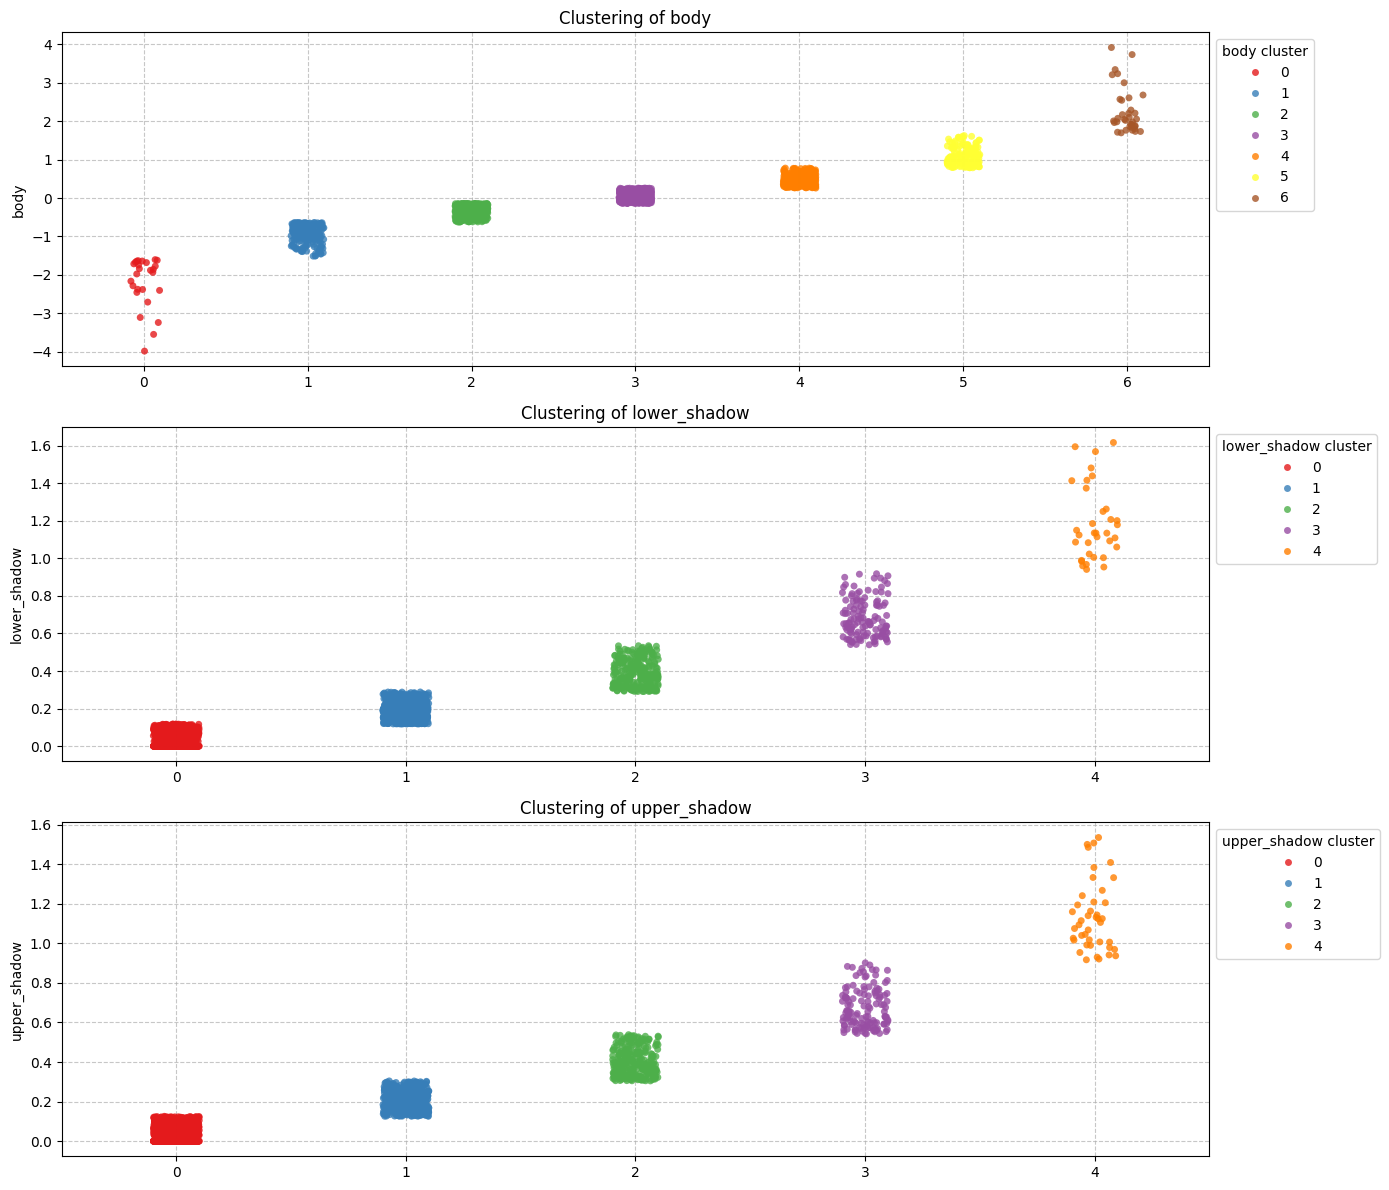

In [14]:
plot_cluster_distribution(data, features=['body', 'lower_shadow', 'upper_shadow'])

## Plot candlestick chart with clustering

In [15]:
middle_data = data_original.iloc[415:425] # part of the graph
middle_data_normalized = data.iloc[415:425]


samples_per_cluster = [min(count, 7) for count in data.sort_values('cluster')['cluster'].value_counts().sort_index()]
cumulative_samples = list(itertools.accumulate(samples_per_cluster, initial=0))

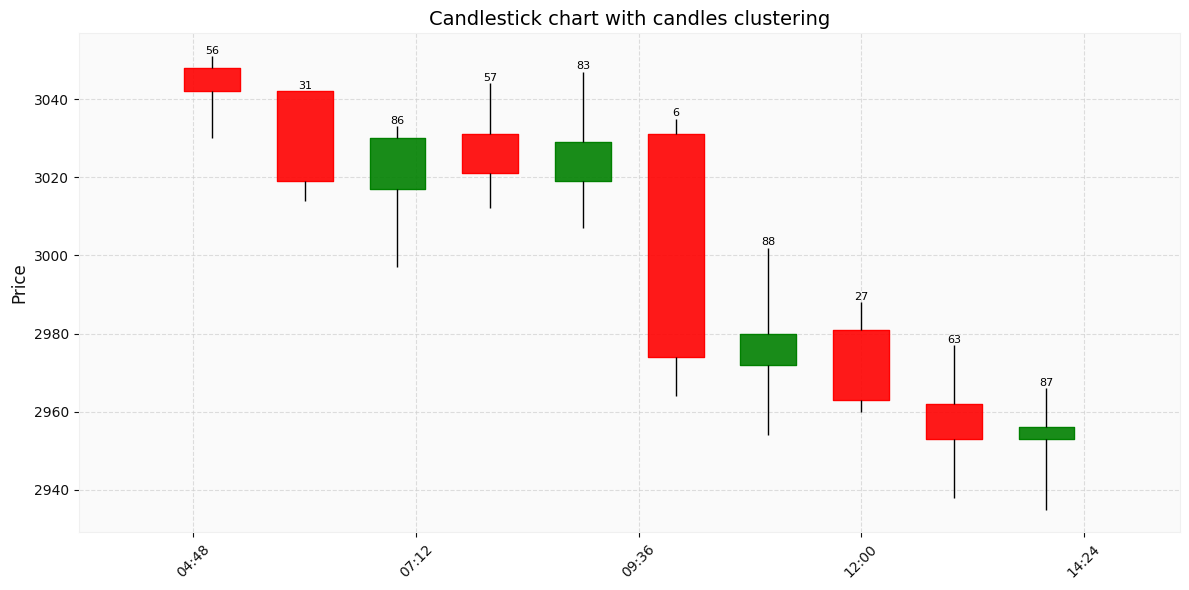

In [17]:
# Configure color and graoh styles
mc = mpf.make_marketcolors(up='g', down='r', wick='black', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)

# Plot a candlestick chart
fig, ax = plt.subplots(figsize=(12, 6))
mpf.plot(middle_data, type='candle', ax=ax, style=s, show_nontrading=True)
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels for the new combined cluster
for i, row in middle_data.iterrows():
    ax.text(row.name, row['High'] + 0.1, int(row['cluster']), 
            fontsize=8, ha='center', va='bottom', color='black')

# Titles and labels
ax.set_title('Candlestick chart with candles clustering', fontsize=14)
ax.set_ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Reinforcement learning

In [23]:
df = pd.read_csv('../outputs/data_with_combined_clusters.csv')
clusters = df['cluster'].unique()
n_clusters = len(clusters)

# Mapear os clusters para estados sequenciais (caso não sejam 0-N)
#cluster_to_state = {c: i for i, c in enumerate(sorted(clusters))}
#df['state'] = df['cluster'].map(cluster_to_state)

# Ações: 0 = comprar, 1 = vender, 2 = segurar
actions = [0, 1, 2]
n_actions = len(actions)

# Inicializar Q-table
q_table = np.zeros((n_clusters, n_actions))

# Hiperparâmetros
alpha = 0.1      # taxa de aprendizado
gamma = 0.95     # fator de desconto
epsilon = 0.1    # exploração
n_episodes = 2000

# Função de recompensa
def get_reward(action, current_close, next_close):
    if action == 0:  # comprar
        return next_close - current_close
    elif action == 1:  # vender
        return current_close - next_close
    else:  # segurar
        return 0

# Episódios
for episode in range(n_episodes):
    total_reward = 0
    for i in range(len(df) - 1):
        state = df.loc[i, 'cluster']
        next_state = df.loc[i+1, 'cluster']
        current_close = df.loc[i, 'Close']
        next_close = df.loc[i+1, 'Close']

        # Escolher ação
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = np.argmax(q_table[state])

        # Calcular recompensa
        reward = get_reward(action, current_close, next_close)
        total_reward += reward

        # Atualizar Q-table
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

    #if episode % 100 == 0:
    print(f'Episódio {episode}: recompensa total = {total_reward:.4f}')

IndexError: index 141 is out of bounds for axis 0 with size 138

In [26]:
data = pd.read_csv('../outputs/dados_cluster.csv')
clusters = data['cluster'].unique()
n_clusters = len(clusters)

# Q-learning parameters
actions = [0, 1, 2]            # 0=buy, 1=sell, 2=hold
n_actions = len(actions)
q_table = np.zeros((n_clusters, n_actions))

alpha = 0.1       # learning rate
gamma = 0.95      # discount factor
epsilon = 0.1     # exploration rate
n_episodes = 2000
initial_cash = 10000

# Reward function
def get_reward(prev_portfolio, cash, shares, price):
    new_portfolio = cash + shares * price
    return new_portfolio - prev_portfolio

# Storage for metrics
episodes = []
final_cash_list = []
shares_remaining = []
action0_count = []
action1_count = []
action2_count = []

# Training loop
for ep in range(1, n_episodes + 1):
    cash = initial_cash
    shares = 0
    portfolio = initial_cash
    actions_taken = []

    for i in range(len(data) - 1):
        state = data.loc[i, 'cluster']
        next_state = data.loc[i + 1, 'cluster']
        price = data.loc[i, 'Close']
        next_price = data.loc[i + 1, 'Close']

        # ε-greedy action
        if random.random() < epsilon:
            a = random.choice(actions)
        else:
            a = np.argmax(q_table[state])
        actions_taken.append(a)

        # execute action
        if a == 0 and cash >= price:
            shares += 1; cash -= price
        elif a == 1 and shares > 0:
            shares -= 1; cash += price
        # hold does nothing

        # reward amd Q-update
        reward = get_reward(portfolio, cash, shares, next_price)
        portfolio = cash + shares * next_price

        old = q_table[state, a]
        q_table[state, a] = (1 - alpha) * old + alpha * (reward + gamma * q_table[next_state].max())

    # record metrics for this episode
    episodes.append(ep)
    final_cash = cash + shares * data.loc[len(data)-1, 'Close']
    final_cash_list.append(final_cash)
    shares_remaining.append(shares)
    cnt = Counter(actions_taken)
    action0_count.append(cnt.get(0, 0))
    action1_count.append(cnt.get(1, 0))
    action2_count.append(cnt.get(2, 0))

    # print summary for this episode
    print(f"Episode {ep}: Final Cash = {final_cash:.2f}, "
          f"Buy={cnt.get(0,0)}, Sell={cnt.get(1,0)}, Hold={cnt.get(2,0)}, "
          f"Shares Left={shares}")

Episode 1: Final Cash = 12445.00, Buy=744, Sell=570, Hold=433, Shares Left=0
Episode 2: Final Cash = 13016.00, Buy=524, Sell=690, Hold=533, Shares Left=0
Episode 3: Final Cash = 12187.00, Buy=518, Sell=767, Hold=462, Shares Left=0
Episode 4: Final Cash = 12528.00, Buy=470, Sell=804, Hold=473, Shares Left=0
Episode 5: Final Cash = 12595.00, Buy=472, Sell=829, Hold=446, Shares Left=0
Episode 6: Final Cash = 11807.00, Buy=438, Sell=840, Hold=469, Shares Left=0
Episode 7: Final Cash = 12539.00, Buy=446, Sell=865, Hold=436, Shares Left=0
Episode 8: Final Cash = 13906.00, Buy=440, Sell=853, Hold=454, Shares Left=0
Episode 9: Final Cash = 14204.00, Buy=435, Sell=857, Hold=455, Shares Left=0
Episode 10: Final Cash = 14135.00, Buy=448, Sell=874, Hold=425, Shares Left=1
Episode 11: Final Cash = 13220.00, Buy=425, Sell=882, Hold=440, Shares Left=0
Episode 12: Final Cash = 13724.00, Buy=434, Sell=883, Hold=430, Shares Left=0
Episode 13: Final Cash = 13099.00, Buy=446, Sell=881, Hold=420, Shares Le

KeyboardInterrupt: 

In [27]:
df = pd.read_csv('../outputs/data_with_combined_clusters.csv')
clusters = df['cluster'].unique()
n_clusters = len(clusters)

# Mapear os clusters para estados sequenciais (caso não sejam 0-N)
cluster_to_state = {c: i for i, c in enumerate(sorted(clusters))}
df['state'] = df['cluster'].map(cluster_to_state)

# Ações: 0 = comprar, 1 = vender, 2 = segurar
actions = [0, 1, 2]
n_actions = len(actions)

# Inicializar Q-table
q_table = np.zeros((n_clusters, n_actions))

# Hiperparâmetros
alpha = 0.1      # taxa de aprendizado
gamma = 0.95     # fator de desconto
epsilon = 0.1    # exploração
n_episodes = 2000

# Função de recompensa
def get_reward(action, current_close, next_close):
    if action == 0:  # comprar
        return next_close - current_close
    elif action == 1:  # vender
        return current_close - next_close
    else:  # segurar
        return 0

# Episódios
for episode in range(n_episodes):
    total_reward = 0
    for i in range(len(df) - 1):
        state = df.loc[i, 'state']
        next_state = df.loc[i+1, 'state']
        current_close = df.loc[i, 'Close']
        next_close = df.loc[i+1, 'Close']

        # Escolher ação
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = np.argmax(q_table[state])

        # Calcular recompensa
        reward = get_reward(action, current_close, next_close)
        total_reward += reward

        # Atualizar Q-table
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

    #if episode % 100 == 0:
    print(f'Episódio {episode}: recompensa total = {total_reward:.4f}')


Episódio 0: recompensa total = 1.2136
Episódio 1: recompensa total = 1.5972
Episódio 2: recompensa total = 1.6520
Episódio 3: recompensa total = 1.7028
Episódio 4: recompensa total = 1.6009
Episódio 5: recompensa total = 1.6583
Episódio 6: recompensa total = 1.6464
Episódio 7: recompensa total = 1.6833
Episódio 8: recompensa total = 1.7068
Episódio 9: recompensa total = 1.6850
Episódio 10: recompensa total = 1.6211
Episódio 11: recompensa total = 1.6959
Episódio 12: recompensa total = 1.6860
Episódio 13: recompensa total = 1.7296
Episódio 14: recompensa total = 1.6286
Episódio 15: recompensa total = 1.6642
Episódio 16: recompensa total = 1.7022
Episódio 17: recompensa total = 1.7081
Episódio 18: recompensa total = 1.7027
Episódio 19: recompensa total = 1.6900
Episódio 20: recompensa total = 1.6350
Episódio 21: recompensa total = 1.6641
Episódio 22: recompensa total = 1.7314
Episódio 23: recompensa total = 1.7237
Episódio 24: recompensa total = 1.7323
Episódio 25: recompensa total = 1.7